In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat 

In [2]:
def rewardnstate(a, s):
    r, state, terminal = P[s][a]
    if s==1 and a==0:
        r = r + np.random.uniform(-1, 1)
    return r, state, terminal

def act_functn(Q, state, state_visits, nAfes):
    #eps = 0.2
    #eps = 1/np.power(state_visits[state], 0.2)
    eps = 1/np.sqrt(state_visits[state])
    if np.random.choice([True, False], p=[1-eps, eps]):
        action = np.argmax(Q[state, :nAfes[state]])
    else:
        action = np.random.choice(nAfes[state])
    return action

In [3]:
def train(epochs, gamma, rewardnstate, act_functn, P, seed=1, alpha=0.05):
    def double_Qlearning(Qa, Qb,
                         cumsum, count,
                         count_matrix_a, maximal_value_a, 
                         maximal_value,
                         rewardnstate, action,
                         state, reward_list,
                         state_visits):
        reward, next_state, terminal = rewardnstate(action, state)
        cumsum += reward
        count += 1
        alpha_a = 1/np.power(count_matrix_a[state, action], p)
        action_star = np.argmax(Qa[next_state, :nAfes[next_state]])
        Qa[state, action] += alpha_a*(reward + gamma*Qb[next_state, action_star] - Qa[state, action])
        count_matrix_a[state, action] += 1
        state_visits[state] += 1
        maximal_value_a.append(np.max(Qa[start_state, :nAfes[start_state]]))
        maximal_value.append(np.max(Qa[start_state, :nAfes[start_state]]))
        reward_list.append((state, action, reward))
        return (reward_list, maximal_value_a,
                maximal_value, state_visits,
                count_matrix_a, Qa,
                next_state, terminal,
                cumsum, count)    
    
    def Qlearning(Qa, cumsum,
                  count, count_matrix_a,
                  maximal_value_a, maximal_value, 
                  rewardnstate,
                  action, state, reward_list,
                  state_visits):
        reward, next_state, terminal = rewardnstate(action, state)
        cumsum += reward
        count += 1
        alpha_a = 1/np.power(count_matrix_a[state, action], p)
        Qa[state, action] += alpha_a*(reward + gamma*np.max(Qa[next_state, :nAfes[next_state]]) - Qa[state, action])
        count_matrix_a[state, action] += 1
        state_visits[state] += 1
        maximal_value_a.append(np.max(Qa[start_state, :nAfes[start_state]]))
        maximal_value.append(np.max(Qa[start_state, :nAfes[start_state]]))
        reward_list.append((state, action, reward))
        return (reward_list, maximal_value_a,
                maximal_value, state_visits,
                count_matrix_a, Qa,
                next_state, terminal,
                cumsum, count)
    
    np.random.seed(seed)
    nS = 2
    nA = 2
    state_visits = np.ones(nS)
    maximal_value = []
    pref_list = []
    pref_learning_list = [] #0: double q learning, 1: q learning 
    cumsum = 0
    count = 0

    Q = np.random.rand(2, nS, nA)
    Q[0, 0] = 0
    Q[1, 0] = 0
    count_matrix = np.ones([2, nS, nA])
    maximal_value_v = [[], []]
    nAfes = [1, 2] #num_Actions_for_each_state
    start_state = 1
    avg_reward_per_step = []
    return_dict = {
            0: {0: []},
            1: {
                0: [], 1: []
            }
        }
    for i in range(epochs):
        reward_list = []
        state = start_state#state = np.random.choice(nS)
        terminal = True if state==0 else False
        choice = np.random.choice([True, False]).astype("int")
        
        while not terminal:
            action = act_functn(Q[choice], state, state_visits, nAfes)
            opt_action = np.argmax(np.mean(Q[:, state], axis=0))
            other_action = 1-opt_action #0 if 1; 1 if 0

            # Double Q learning is preferred if 
            #  we have more than 2 previous returns for a state action pair
            #  and the variance of return is less a threshold
            # In case either of the above two criteria are not followed
            # Q learning is preferred. 
            
            if(len(return_dict[state][action]) >= 2):
                if(np.var(return_dict[state][opt_action])<np.var(return_dict[state][other_action])):
                    
                    
                    choice2 = np.random.choice([True, False]).astype("int")                    
                    (reward_list, maximal_value_v[choice2],
                      maximal_value, state_visits,
                      count_matrix[choice2], Qc2, next_state,
                      terminal, cumsum, 
                     count) = double_Qlearning(Q[choice2], Q[1-choice2],
                                              cumsum, count,
                                              count_matrix[choice2], 
                                              maximal_value_v[choice2],
                                               maximal_value,
                                              rewardnstate, action,
                                              state, reward_list,
                                              state_visits)
                    Q[choice2] = Qc2
                    pref_learning_list.append(0) #Double qlearning
                else:
                    
                    (reward_list, maximal_value_v[choice],
                    maximal_value, state_visits,
                    count_matrix[choice], Q[choice], next_state,
                    terminal, cumsum, count) = Qlearning(Q[choice], cumsum,
                                                          count, count_matrix[choice],
                                                          maximal_value_v[choice], 
                                                          maximal_value,
                                                          rewardnstate, action, 
                                                          state, reward_list,
                                                          state_visits)
                    pref_learning_list.append(1) #qlearning
            else:
                
                (reward_list, maximal_value_v[choice],
                 maximal_value, state_visits,
                 count_matrix[choice], Q[choice], next_state,
                 terminal, cumsum, count) = Qlearning(Q[choice], cumsum,
                                                      count, count_matrix[choice],
                                                      maximal_value_v[choice], 
                                                      maximal_value,
                                                      rewardnstate, action, 
                                                      state, reward_list,
                                                      state_visits)
                pref_learning_list.append(1) #qlearning
            state = next_state
            reward_sum = 0
            for i in range(len(reward_list)-1, -1, -1):
                reward_sum = gamma*reward_sum + reward_list[i][2]
                return_dict[reward_list[i][0]][reward_list[i][1]].append(reward_sum)

        pref = .0
        pref += Q[0][1][0] - Q[0][1][1] #preference of left over right
        pref += Q[1][1][0] - Q[1][1][1] #preference of left over right
        pref /= float(2)
        pref_list.append(pref)
        avg_reward_per_step.append(cumsum/count)
    return (avg_reward_per_step, pref_list, pref_learning_list, 
            Q[0], Q[1], maximal_value_v[0], maximal_value_v[1], 
            maximal_value, return_dict)

In [5]:
N = 3
alpha = 0.01
gamma = 0.99
epochs = 2000
p = 0.8
for i in [1]:
    mu = i
    P = {
        0:{0: (0, 0, True)}, #state:{action: (reward, next state, terminal)}
        1:{0: (mu, 0, True),
           1: (0, 0, True)}
    }
    (reward_list, pref_list,
     pref_learning_list, Qa,
     Qb, maximal_value_a,
     maximal_value_b, maximal_value,
     return_dict) = train(epochs, gamma, rewardnstate, act_functn, P)
    print(pref_list[-1])

1.0370942404188357


In [6]:
pref_learning_array = np.array(pref_learning_list)
maximal_value_array = np.array(maximal_value)
qchosen = (pref_learning_array).nonzero()[0]
qchosen_maximal_value = maximal_value_array[qchosen]
dqchosen =(1-pref_learning_array).nonzero()[0]
dqchosen_maximal_value = maximal_value_array[dqchosen]
len(qchosen), len(qchosen_maximal_value), len(dqchosen), len(dqchosen_maximal_value)

(2000, 2000, 0, 0)

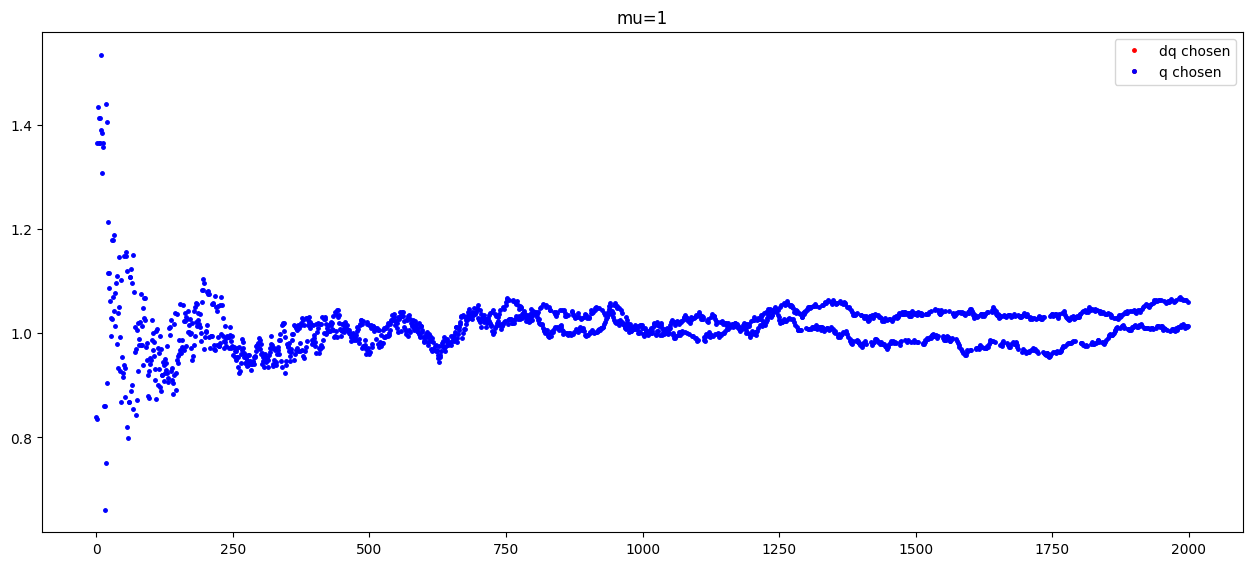

In [7]:
fig, ax = plt.subplots()
red_dot, = ax.plot(dqchosen, dqchosen_maximal_value, "r.", markersize=5)
blue_dot, = ax.plot(qchosen,qchosen_maximal_value, "b.",  markersize=5)

ax.legend([red_dot, (red_dot, blue_dot)], ["dq chosen", "q chosen"])
fig.set_size_inches(15.5, 6.5, forward=True)
plt.title("mu={}".format(mu))
plt.show()

In [64]:
np.argmax(np.array([0, 1]))

1